# Admissions and Transfers data set with trend and Seasonality Factors added

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta



# Define the mode_of_arrival options
mode_of_arrival_options = ['Ambulance', 'Own Vehicle', 'Walk In', 'Other']

# Define the disposition options
disposition_options = ['HOME', 'ADMITTED', 'ELOPED', 'TRANSFER', 'LEFT WITHOUT BEING SEEN', 'OTHER', 'LEFT AGAINST MEDICAL ADVICE', 'EXPIRED']

# Set a seed for reproducibility (optional)
random.seed(2020)

# List of values specifying the number of IDs to generate for each month
original_num_ids_list = [55, 41, 50, 44, 45, 55, 41, 40, 47, 53, 50, 52]

# Define the scaling factor
scaling_factor = 20

# Calculate the scaled number of IDs for each month
num_ids_list = [int(original_num_ids * scaling_factor) for original_num_ids in original_num_ids_list]

# Define the start and end years, including a leap year
start_year = 2015
end_year = 2020

# Define the filename for the output file
output_filename = "data_2015_to_2020_scaling_with_end_date_mode_of_arrival_disposition_seasonlity.csv"

# Create an empty list to store data
data = []

# Loop through each year
for year in range(start_year, end_year + 1):
    # Introduce a linear trend for the number of IDs
    trend_factor = (year - start_year + 1) * 2  # Adjust the trend factor as needed
    num_ids_list_with_trend = [int(num_ids * trend_factor) for num_ids in num_ids_list]

    # Determine if the current year is a leap year
    is_leap_year = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)

    # Loop through each month
    for month, num_ids in enumerate(num_ids_list_with_trend, start=1):
        # Introduce seasonality by varying the number of IDs based on the month
        seasonality_factor = 1 + np.sin(2 * np.pi * (month - 1) / 12)  # Adjust the seasonality factor as needed
        num_ids = int(num_ids * seasonality_factor)

        # Determine the number of days in the current month
        if month == 2 and is_leap_year:
            last_day = 29  # February in a leap year
        else:
            last_day = 28  # Initialize with a safe value
            try:
                last_day = (datetime(year, month + 1, 1) - timedelta(days=1)).day
            except ValueError:
                pass

        # Generate random IDs, start dates, end dates, mode_of_arrival, and disposition for the current month
        for _ in range(num_ids):
            day = random.randint(1, last_day)  # Generate a random day within the month
            start_date = datetime(year, month, day)
            end_date = start_date + timedelta(days=random.randint(1, 30))  # Generate a random end date within 30 days
            id_value = random.randint(1000000, 99999999)  # Generate 8 digits Patient IDs
            arrival_mode = random.choice(mode_of_arrival_options)
            disposition = random.choice(disposition_options)
            data.append([start_date, end_date, id_value, arrival_mode, disposition])

# Create a Pandas DataFrame from the data
master_data = pd.DataFrame(data, columns=["Admission Date", "Discharge Date", "Patient ID", "Mode of Arrival", "Disposition"])

# Save the DataFrame to a CSV file
master_data.to_csv(output_filename, index=False)

print("DataFrame and CSV file saved successfully.")

# Print the first few rows of the DataFrame
print(master_data.head())


DataFrame and CSV file saved successfully.
  Admission Date Discharge Date  Patient ID Mode of Arrival  \
0     2015-01-20     2015-02-09    24424196           Other   
1     2015-01-16     2015-01-28    57279250     Own Vehicle   
2     2015-01-15     2015-02-10    33220210     Own Vehicle   
3     2015-01-22     2015-01-29    82137812     Own Vehicle   
4     2015-01-15     2015-01-19    95712788     Own Vehicle   

                   Disposition  
0                      EXPIRED  
1                     ADMITTED  
2  LEFT AGAINST MEDICAL ADVICE  
3                      EXPIRED  
4                      EXPIRED  


In [2]:
# Convert "Start Date" column to datetime
master_data['Admission Date'] = pd.to_datetime(master_data['Admission Date'])

# Extract the month from the "Start Date" and create a new column "Start Month"
master_data['Admission Date Year Month'] = master_data['Admission Date'].dt.strftime('%Y-%m')
master_data['Admission Date Year'] = master_data['Admission Date'].dt.strftime('%Y')

# Group the data by "Start Month" and get the average count of IDs for each unique start month
start_month_count_ids = master_data.groupby("Admission Date Year Month")["Patient ID"].count().reset_index()
year_count_ids = master_data.groupby("Admission Date Year")["Patient ID"].count().reset_index()

# Rename the columns for clarity
start_month_count_ids.columns = ["Admission Date Year Month", "Patient ID Count"]
year_count_ids.columns = ['Admission Date Year', 'Patient Count ID']

# Print the resulting DataFrame
print(start_month_count_ids.head())
print(year_count_ids)

  Admission Date Year Month  Patient ID Count
0                   2015-01              2200
1                   2015-02              2460
2                   2015-03              3732
3                   2015-04              3520
4                   2015-05              3358
  Admission Date Year  Patient Count ID
0                2015             22567
1                2016             45138
2                2017             67709
3                2018             90280
4                2019            112851
5                2020            135422


In [3]:
start_date_counts = master_data.groupby("Admission Date")["Patient ID"].count().reset_index()

# Rename the columns for clarity
start_date_counts.columns = ["Admission Date", "Patient ID Count"]

# Print the resulting DataFrame
start_date_counts.head()

,Admission Date,Patient ID Count
0,2015-01-01,63
1,2015-01-02,75
2,2015-01-03,82
3,2015-01-04,68
4,2015-01-05,71


ADF Statistic: -2.2952509148608713
p-value: 0.17350422113700698
Critical Values:
   1%: -3.433648628001351
   5%: -2.8629971502062155
   10%: -2.5675457254979093


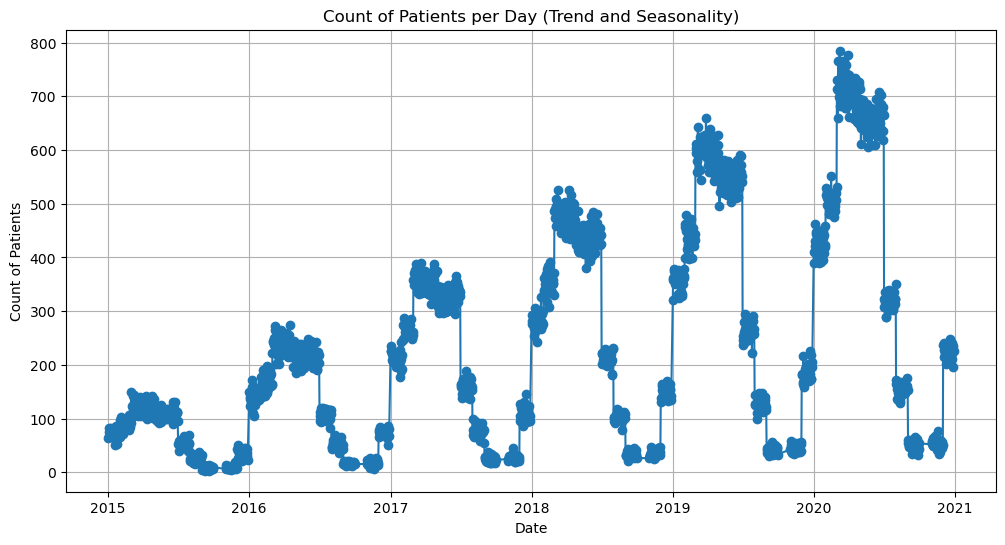

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


# Group the data by "Admission Date" and get the count of patients for each day
daily_counts = master_data.groupby(master_data['Admission Date'].dt.date)['Patient ID'].count()

# Perform the ADF test
result = adfuller(daily_counts)

# Extract and print the ADF test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Create a line graph to visualize the trend and seasonality
plt.figure(figsize=(12, 6))
plt.plot(daily_counts.index, daily_counts.values, marker='o', linestyle='-')

# Customize the plot
plt.xlabel("Date")
plt.ylabel("Count of Patients")
plt.title("Count of Patients per Day (Trend and Seasonality)")
plt.grid(True)

# Show the plot
plt.show()


In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pl

# Extract the "Admission Date" and "Patient ID" columns
data = master_data[['Admission Date', 'Patient ID']]

data['year_admission_date']=data['Admission Date'].dt.strftime('%Y').astype(int)
data['month_admission_date']=data['Admission Date'].dt.strftime('%m').astype(int)
data[['year_admission_date','month_admission_date']]

C:\Users\krishika.R\AppData\Local\Temp\ipykernel_6840\4186736686.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year_admission_date']=data['Admission Date'].dt.strftime('%Y').astype(int)
C:\Users\krishika.R\AppData\Local\Temp\ipykernel_6840\4186736686.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['month_admission_date']=data['Admission Date'].dt.strftime('%m').astype(int)


,year_admission_date,month_admission_date
0,2015,1
1,2015,1
2,2015,1
3,2015,1
4,2015,1
...,...,...
473962,2020,12
473963,2020,12
473964,2020,12
473965,2020,12


In [6]:
# ALl Data
data_X = data
data_X = data_X.groupby('Admission Date')['Patient ID'].count().reset_index()
data_X.columns = ['Admission Date', 'Patient Count']
data_X.head()

# Train dataset with 5 years data: 2015, 2016, 2017, 2018 & 2019 
train_data = data[data['year_admission_date']== 2019]
print(train_data.groupby('year_admission_date')['Patient ID'].count())
train_dataset = train_data.groupby('Admission Date')['Patient ID'].count().reset_index()
train_dataset.columns = ['Admission Date', 'Patient Count']
train_dataset.head()
# Validation dataset with 6 months: 2020-01-01 to '2020-06-30'
validation_data = data[(data['year_admission_date'] == 2020) & (data['month_admission_date'] <= 6)]
print(validation_data.groupby('month_admission_date')['Patient ID'].count())
validation_dataset = (validation_data.groupby('Admission Date')['Patient ID'].count()).reset_index()
validation_dataset.columns = ['Admission Date', 'Patient Count']
validation_dataset.head()
# Test dataset with 6 months: 2020-07-01 to '2020-12-31'
test_data = data[data['year_admission_date'] >= 2020 & (data['month_admission_date'] > 6)]
print(test_data.groupby('year_admission_date')['Patient ID'].count())
test_dataset = test_data.groupby('Admission Date')['Patient ID'].count().reset_index()
test_dataset.columns = ['Admissions Date','Patient Count']
test_dataset.head()

year_admission_date
2019    112851
Name: Patient ID, dtype: int64
month_admission_date
1    13200
2    14760
3    22392
4    21120
5    20153
6    19800
Name: Patient ID, dtype: int64
year_admission_date
2015     22567
2016     45138
2017     67709
2018     90280
2019    112851
2020    135422
Name: Patient ID, dtype: int64


,Admissions Date,Patient Count
0,2015-01-01,63
1,2015-01-02,75
2,2015-01-03,82
3,2015-01-04,68
4,2015-01-05,71


In [7]:
# Perform the ADF test
result = adfuller(train_dataset['Patient Count'])
adf_statistic = result[0]
p_value = result[1]

# Print ADF test results
print("ADF Statistic:", adf_statistic)
print("P-Value:", p_value)

ADF Statistic: -0.996255356418608
P-Value: 0.7546276224164317


In [9]:
best_mse = float('inf')
best_order = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            order = (p, d, q)
            model = SARIMAX(train_dataset['Patient Count'], order=order)
            model_fit = model.fit(disp=0)
            predictions = model_fit.predict(start=len(train_dataset['Patient Count']), end=len(train_dataset['Patient Count']) + len(validation_dataset['Patient Count']) - 1)
            mse = mean_squared_error(validation_dataset['Patient Count'], predictions)
            if mse < best_mse:
                best_mse = mse
                best_order = order

print("Best AIC:", best_mse)
print("Best Order (p, d, q):", best_order)

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best AIC: 183263.61306391424
Best Order (p, d, q): (1, 1, 0)


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Fit ARIMA model to the training dataset
order = (0,1,0)  
model = SARIMAX(train_dataset['Patient Count'], order=order,seasonal_order = (1,1,1,12))
model_fit = model.fit(disp=0)

# Make predictions on the validation dataset
validation_predictions = model_fit.predict(start=len(train_dataset['Patient Count']), end=len(train_dataset['Patient Count']) + len(validation_dataset['Patient Count']) - 1)

# Calculate performance metrics for the validation set
mse = mean_squared_error(validation_dataset['Patient Count'], validation_predictions)
mae = mean_absolute_error(validation_dataset['Patient Count'], validation_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(validation_dataset['Patient Count'], validation_predictions)
mape = mean_absolute_percentage_error(validation_dataset['Patient Count'], validation_predictions)

print("Validation MSE:", mse)
print("Validation MAE:", mae)
print("Validation RMSE:", rmse)
print("Validation R-squared:", r2)
print("Validation MAPE:", mape)

Validation MSE: 212318.32173689624
Validation MAE: 443.72569930119244
Validation RMSE: 460.7801229837245
Validation R-squared: -16.324261558661416
Validation MAPE: 70.91227005608336


## To Be Worked On

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

datasets = {
    "All Data": data_X['Patient Count'],
    "Train Data": train_dataset['Patient Count'],
    "Validation Data": validation_dataset['Patient Count'],
    "Test Data": test_dataset['Patient Count']
}

# Create a grid of ACF and PACF plots
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for i, (data_label, data) in enumerate(datasets.items()):
    # ACF plot
    ax1 = axes[i, 0]
    plot_acf(data, lags=40, ax=ax1)
    ax1.set_title(f'ACF Plot - {data_label}')
    
    # PACF plot
    ax2 = axes[i, 1]
    plot_pacf(data, lags=40, ax=ax2)
    ax2.set_title(f'PACF Plot - {data_label}')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from itertools import product

# Extract the "Admission Date" and "Patient ID" columns
data = train_data

# Define a range of p, d, q, P, D, and Q values to search over
p_values = range(0, 3)  # Example range, adjust as needed
d_values = range(0, 2)  # Example range, adjust as needed
q_values = range(0, 3)  # Example range, adjust as needed
P_values = range(0, 3)  # Example range, adjust as needed
D_values = range(0, 2)  # Example range, adjust as needed
Q_values = range(0, 3)  # Example range, adjust as needed

best_order = None
best_seasonal_order = None
best_aic = np.inf

# Perform a grid search over the parameter space
for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    seasonal_order = (P, D, Q, 12)  # Adjust the seasonality (12 for monthly data)
    try:
        model = sm.tsa.SARIMAX(data['Patient ID'], order=(p, d, q), seasonal_order=seasonal_order)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_order = (p, d, q)
            best_seasonal_order = seasonal_order
            best_aic = results.aic
    except:
        continue

print(f"Best SARIMAX Order: {best_order}")
print(f"Best Seasonal Order: {best_seasonal_order}")
print(f"Best AIC: {best_aic}")


In [ ]:
# SARIMAX Model
#exog = ...  # Define your exogenous variables (if any)
sarimax_model = SARIMAX(train_data['Patient ID'], order=(1, 1, 0), seasonal_order=(1, 1, 1, 12))
sarimax_results = sarimax_model.fit()

In [ ]:
# Evaluate the models
test_data['Lag1'] = test_data['Patient ID'].shift(1)
test_data.dropna(inplace=True)
X_test = test_data[['Lag1']]
y_test = test_data['Patient ID']

# SARIMAX predictions
sarimax_preds = sarimax_results.get_forecast(steps=len(test_data), exog=exog)
sarimax_pred_values = sarimax_preds.predicted_mean

# Calculate RMSE for both models
sarimax_rmse = np.sqrt(mean_squared_error(y_test, sarimax_pred_values))

print(f"SARIMAX RMSE: {sarimax_rmse}")


# Plot the predicted vs. actual values for one of the models
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, sarimax_pred_values, label='SARIMAX Predicted')
plt.xlabel("Date")
plt.ylabel("Count of Patients")
plt.title("SARIMAX vs. Actual")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Load the data from your CSV file (replace 'your_data_file.csv' with your actual file path)
df = pd.read_csv('data_2015_to_2020_scaling_with_end_date_mode_of_arrival_disposition.csv')

# Convert "Admission Date" column to datetime
df['Admission Date'] = pd.to_datetime(df['Admission Date'])

# Extract the "Admission Date" and "Patient ID" columns
data = df[['Admission Date', 'Patient ID']]

# Split the data into training and testing sets (adjust the split ratio as needed)
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# SARIMAX Model
#exog = ...  # Define your exogenous variables (if any)
sarimax_model = SARIMAX(train_data['Patient ID'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_results = sarimax_model.fit()

# Regression-Based Model (Random Forest, for example)
# Create lag features (previous time steps) as predictors
train_data['Lag1'] = train_data['Patient ID'].shift(1)
train_data.dropna(inplace=True)
X_train = train_data[['Lag1']]
y_train = train_data['Patient ID']

# Train the regression model
regression_model = RandomForestRegressor(n_estimators=100, random_state=42)
regression_model.fit(X_train, y_train)

# Evaluate the models
test_data['Lag1'] = test_data['Patient ID'].shift(1)
test_data.dropna(inplace=True)
X_test = test_data[['Lag1']]
y_test = test_data['Patient ID']

# SARIMAX predictions
sarimax_preds = sarimax_results.get_forecast(steps=len(test_data), exog=exog)
sarimax_pred_values = sarimax_preds.predicted_mean

# Regression-based model predictions
regression_pred_values = regression_model.predict(X_test)

# Calculate RMSE for both models
sarimax_rmse = np.sqrt(mean_squared_error(y_test, sarimax_pred_values))
regression_rmse = np.sqrt(mean_squared_error(y_test, regression_pred_values))

print(f"SARIMAX RMSE: {sarimax_rmse}")
print(f"Regression RMSE: {regression_rmse}")

# Plot the predicted vs. actual values for one of the models
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, sarimax_pred_values, label='SARIMAX Predicted')
plt.xlabel("Date")
plt.ylabel("Count of Patients")
plt.title("SARIMAX vs. Actual")
plt.legend()
plt.grid(True)
plt.show()